# Visualizing RST and layout structures in GeM corpora

This Jupyter notebook is intended for visualizing discourse structures in multimodal documents, as described using <a href="http://www.sfu.ca/rst/">Rhetorical Structure Theory</a> and annotated using the schema provided by the <a href="http://www.fb10.uni-bremen.de/anglistik/langpro/projects/gem/newframe.html">Genre and Multimodality</a> model.

For visualizing the RST and layout structures, you need valid XML files for base, RST and layout layers. The content is retrieved from the base layer, before drawing out the rhetorical relations between the content and organizing it into the hierarchy defined in the layout structure.

## 1. Import the necessary packages.

In [14]:
# For parsing XML
from lxml import etree as et

# For formatting the content
import textwrap
import codecs

# For testing
from IPython.display import Image

Check GraphViz installation.

In [15]:
graphviz_installed = !which dot
if graphviz_installed == '':
    print "Graphviz/DOT not found. Exiting ..."
    quit()
else:
    print "Graphviz/DOT found ..."

Graphviz/DOT found ...


## 2. Parse the GeM XML files.

Define the base and RST files below.

In [16]:
basefile = 'test_xml/2002-she-base-1.xml' # Base layer
rstfile = 'test_xml/2002-she-rst-1.xml' # RST layer
layoutfile = 'test_xml/2002-she-layout-1.xml' # Layout layer

Define a function to parse the XML files.

In [17]:
def parse_xml(basefile, rstfile, layoutfile):
    
    ##### PARSE BASE UNITS #####
    
    base_units = {} # Set up a dictionary for the base units
    baseroot = et.parse(basefile).getroot() # Parse the XML file and get XML root
    for unit in baseroot.findall('.//unit'):
        unit_id = unit.attrib['id']
        if 'alt' in unit.attrib:
            unit_content = unit.attrib['alt'], ', fontsize="12.0", shape="box"];\n'
        else:
            unit_content = textwrap.fill(''.join(unit.itertext()), 35).replace("\"", "'"), ', fontsize="12.0", shape="box", style="filled", color="white"];\n'
        base_units[unit_id] = unit_content # Populate dictionary with key (id) and value (content) pairs
            
    rst_segments = {} # Set up a dictionary for the RST units
    rst_base_mapping = {} # Set up a dictionary for mapping the RST units to the base units
    rstroot = et.parse(rstfile).getroot()
    
    ##### PARSE RST UNITS #####
    
    for rst_segment in rstroot.findall('.//segment'):
        rst_segment_id, rst_segment_xref = rst_segment.attrib['id'], rst_segment.attrib['xref']
        rst_segment_content = base_units[rst_segment_xref]
        rst_segments[rst_segment_id] = rst_segment_content
        rst_base_mapping[rst_segment_xref] = rst_segment_id
        
    for mini_segment in rstroot.findall('.//mini-segment'):
        mini_segment_id, mini_segment_xref = mini_segment.attrib['id'], mini_segment.attrib['xref']
        mini_segment_content = base_units[mini_segment_xref]
        rst_segments[mini_segment_id] = mini_segment_content
        rst_base_mapping[mini_segment_xref] = mini_segment_id
    
    rst_segment_span_mapping = {}
    rst_relations = {}

    for rst_structure in rstroot.findall('rst-structure'):
        for span in rst_structure.getchildren():
            rst_relations[span.attrib['id']] = span.attrib['relation'].upper(), ', fontcolor="crimson", fontsize="10.0", shape="plaintext"];\n'
            if span.tag == 'span':
                rst_segment_span_mapping[span.attrib['id']] = span.attrib['nucleus'].split(), span.attrib['satellites'].split()
            if span.tag == 'multi-span':
                rst_segment_span_mapping[span.attrib['id']] = span.attrib['nuclei'].split()
            if span.tag == 'mini-span':
                rst_segment_span_mapping[span.attrib['id']] = span.attrib['attribuend'].split(), span.attrib['attribute'].split()
    
    ##### PARSE LAYOUT UNITS #####

    layout_units = {} # Set up a dictionary for the layout units
    layoutroot = et.parse(layoutfile).getroot()

    for layout_unit in layoutroot.xpath('.//segmentation/layout-unit'): # Use XPath to skip nested layout units
        layout_unit_id = layout_unit.attrib['id']
        layout_unit_xref = layout_unit.attrib['xref'].split()
        layout_units[layout_unit_id] = layout_unit_xref

    ##### Parse the layout leafs ad ##### 
    
    for layout_leaf in layoutroot.iter('layout-leaf'):
        xref, layout_chunk, base_units = layout_leaf.attrib['xref'], layout_leaf.getparent().attrib['id'], layout_units[layout_leaf.attrib['xref']]
        layout_units[xref] = base_units, layout_chunk
    
    return rst_segments, rst_relations, rst_base_mapping, rst_segment_span_mapping, rstroot, layout_units, layoutroot

In [18]:
rst_segments, rst_relations, rst_base_map, rst_segment_span_map, rstroot, layout_units, layoutroot = parse_xml(basefile, rstfile, layoutfile)

## 3. Draw the RST graph.

Open a file for the graph; use UTF-8 encoding. Set up the beginning and the end of the graph.

In [28]:
graph = codecs.open('rst_layout_graph.gv', 'w', 'utf-8')

begin_graph = 'digraph "rstgraph" { graph [rankdir="BT"];\n'
terminate_graph = '}\n'

Begin writing the graph.

In [29]:
# Print the DOT graph preamble
# print begin_graph
graph.write(begin_graph)

##### EXAMINE THE LAYOUT STRUCTURE ##### 

# Map the RST segments to the layout chunks
rst_layout_chunk_mapping = {}
for chunks in layoutroot.findall('.//layout-chunk'): # Find all layout chunks
    chunk_id = chunks.attrib['id'] # Fetch unique chunk identifier    
    for leaf in layout_units: # Loop through layout units
        base_unit_id, chunk = layout_units.get(leaf) # Unpack layout units tuple
        if chunk == chunk_id:
            for base_unit in base_unit_id:
                if base_unit in rst_base_mapping.keys():
                    rst_layout_chunk_mapping[rst_base_mapping[base_unit]] = chunk

##### BEGIN WRITING SUBGRAPHS #####
                    
for chunk in layoutroot.findall('.//layout-chunk'):
    print_chunk = '\tsubgraph ', chunk.attrib['id'], ' {\n'
    graph.write("".join(print_chunk))
    for rst_segment, layout_chunk in rst_layout_chunk_mapping.items(): # Split the dictionary
        if chunk.attrib['id'] == layout_chunk: # Match chunks
            
            # Add RST segments to subgraph
            for node in sorted(rst_segments):
                if node == rst_segment:
                    content, style = rst_segments.get(node)
                    print_node = '"', node, '"\t[label="', content, '"', style
                    graph.write("".join(print_node))
            
    # Terminate subgraph        
    graph.write(terminate_graph)
                      
graph.write(terminate_graph)

In [116]:
# Print the DOT graph preamble
# print begin_graph
graph.write(begin_graph)

# Add RST spans to the graph
for span in sorted(rst_relations):
    relation, style = rst_relations.get(span)
    print_span = '"', span, '"\t[label="', relation, '"', style
    graph.write("".join(print_span))
    
# Add RST segments to the graph
for node in sorted(rst_segments):
    content, style = rst_segments.get(node)
    print_node = '"', node, '"\t[label="', content, '"', style
    graph.write("".join(print_node))
            
# Add edges
for span in rstroot.findall('.//rst-structure/*'):
    if span.tag == 'multi-span':
        multispan, nuclei, relation = span.attrib['id'], span.attrib['nuclei'].split(), span.attrib['relation']
        if span.attrib['id'] == multispan:
            for n in nuclei:
                print_nuclei = '"', n, '" -> ', '"', multispan, '"\t [dir="back"];\n'
                graph.write("".join(print_nuclei))

    if span.tag == 'span':
        spanid, nucleus, satellites, relation = span.attrib['id'], span.attrib['nucleus'].split(), span.attrib['satellites'].split(), span.attrib['relation']
        if span.attrib['id'] == spanid:
            for n in nucleus:
                print_nucleus = '"', n, '" -> ', '"', spanid, '"\t [dir="back"];\n'
                graph.write("".join(print_nucleus))
            for s in satellites:
                print_satellites = '"', s, '" -> ', '"', spanid, '"\t [dir="none"];\n'
                graph.write("".join(print_satellites))
                
    for title in span.iter('title'):
        target_id = span.attrib['id']
        title_xref = title.attrib['xref']
        if span.attrib['id'] == target_id:
            print_title = '"', title_xref, '" -> ', '"', target_id, '"\t [dir="none", style="dashed"];\n'
            graph.write("".join(print_title))

graph.write(terminate_graph)

Close the graph file.

In [42]:
graph.close()

Use DOT draw the graph.

In [14]:
!dot -Tpng graph.gv > graph.png

Show the resulting image in the IPython notebook.

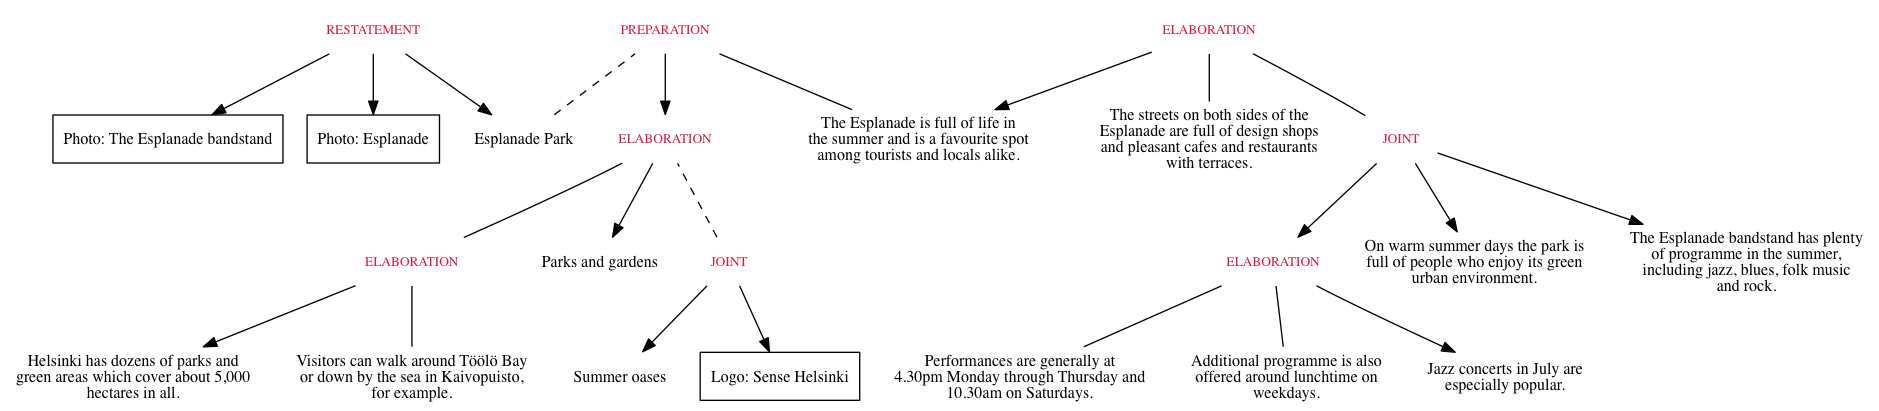

In [15]:
Image('graph.png')